In [ ]:
#pip install kaggle

In [ ]:
#pip install xgboost

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import zipfile

In [4]:
# Set competition name (slug from URL)
competition_name = "playground-series-s5e1"

# Define output directory for the data
output_dir = "."
os.makedirs(output_dir, exist_ok=True)

# Download competition data using Kaggle API
os.system(f"kaggle competitions download -c {competition_name} -p {output_dir}")

print(f"Competition data downloaded to: {output_dir}")

playground-series-s5e1.zip: Skipping, found more recently modified local copy (use --force to force download)
Competition data downloaded to: .


In [5]:
zip_file_path = competition_name + '.zip'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    print("Files in zip:", z.namelist())
    z.extractall()
    #csv_file_name = z.namelist()[0]

Files in zip: ['sample_submission.csv', 'test.csv', 'train.csv']


In [6]:
import matplotlib.pyplot as plt
from datetime import datetime
import time
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Data

In [7]:
data_pack = pd.read_csv("train.csv")
inference_pack = pd.read_csv("test.csv")

Display the shape of the training dataframe and the first five rows

In [8]:
print('(rows,columns) = ',data_pack.shape)
data_pack.head(5)

(rows,columns) =  (230130, 6)


,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


## Preprocessing dates

Let's convert the dates into the datetime format to separate it into features like days, months, etc.

In [10]:
# Date categories that we will use in our analysis
date_categories = ['dayofweek','dayofyear','dayofmonth','weekofyear','quarter','month']

# The year that preceds the first year in our dataset
first_year = float((data_pack.loc[0,'date'])[:4])-1
# The first date in the dataset
first_day = data_pack.loc[0,'date']

# We also turn the categorical features into the 'category' type right away, as it will be needed to run XGBoost later
group_categories = ['country','store','product'] # we will use these categories to form groups almost everywhere in this notebook
data_pack[group_categories] = data_pack[group_categories].astype('category')
inference_pack[group_categories] = inference_pack[group_categories].astype('category')

In [11]:
def datetime_processing(df):

    df_new = df.copy()
    df_date = pd.to_datetime(df['date'])
    df_new.loc[:,'date'] = df_date
    
    df_new['dayofweek'] = df_date.dt.dayofweek
    df_new['quarter'] = df_date.dt.quarter
    df_new['month'] = df_date.dt.month
    df_new['year'] = df_date.dt.year - first_year
    df_new['dayofyear'] = df_date.dt.dayofyear
    df_new['dayofmonth'] = df_date.dt.day
    df_new['weekofyear'] = (df_new['dayofyear'] // 7) + 1

    df_new['oddyear'] = df_date.dt.year % 2
    df_new['daysfromstart'] = df_new['dayofyear'] + 365*(df_new['year'] - 1.0)

    return df_new

In [12]:
data_pack_dt = datetime_processing(data_pack)
data_pack_dt.head(2)

,id,date,country,store,product,num_sold,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,oddyear,daysfromstart
0,0,2010-01-01 00:00:00,Canada,Discount Stickers,Holographic Goose,NaN,4,1,1,1.0,1,1,1,0,1.0
1,1,2010-01-01 00:00:00,Canada,Discount Stickers,Kaggle,973.0,4,1,1,1.0,1,1,1,0,1.0


## NaNs

In [13]:
# Check if a column has any NaN values
# data_pack['store'].isna().any()

# Show how many NaNs are in num_sold column
NaN_count = data_pack['num_sold'].isna().sum()
print('NaNs in num_sold = ',NaN_count)
print(f'NaNs constitute {round(100*NaN_count/data_pack.shape[0],2)}% of the data')

NaNs in num_sold =  8871
NaNs constitute 3.85% of the data


Let's examine the NaNs by splitting them into groups of categories

In [70]:
data_pack_nans = data_pack[data_pack['num_sold'].isna()] 

nans_grouped = data_pack_nans.groupby(group_categories,observed=True)

for group_name, group_data in nans_grouped:
    print(f'{group_name}: {group_data.shape[0]} NaNs')

('Canada', 'Discount Stickers', 'Holographic Goose'): 2557 NaNs
('Canada', 'Discount Stickers', 'Kerneler'): 1 NaNs
('Canada', 'Premium Sticker Mart', 'Holographic Goose'): 380 NaNs
('Canada', 'Stickers for Less', 'Holographic Goose'): 1308 NaNs
('Kenya', 'Discount Stickers', 'Holographic Goose'): 2557 NaNs
('Kenya', 'Discount Stickers', 'Kerneler'): 63 NaNs
('Kenya', 'Discount Stickers', 'Kerneler Dark Mode'): 1 NaNs
('Kenya', 'Premium Sticker Mart', 'Holographic Goose'): 646 NaNs
('Kenya', 'Stickers for Less', 'Holographic Goose'): 1358 NaNs


Although two combinations of categories have no other values than NaNs and some other combinations have a big proportions of NaNs, for the first trial let's assume that we can safely neglect all of them and our algorithm will be efficient enough to predict the sales in these combinations of categories

In [15]:
data_pack_nonans = data_pack_dt.dropna() 

## Data representation

Let's group the data and analyze it visually to get some insights

In [16]:
data_grouped = data_pack_dt.groupby(group_categories,observed=True)

In [17]:
def plot_group(df,df2 = pd.DataFrame()): # the second argument is optional (can be used for comparison)

    plt.figure()
    plt.plot(df.date.to_numpy(),df.num_sold.to_numpy())
    if not df2.empty:
        plt.plot(df2.date.to_numpy(),df2.num_sold.to_numpy(),marker='o',linestyle='None')
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid()
    plt.show()

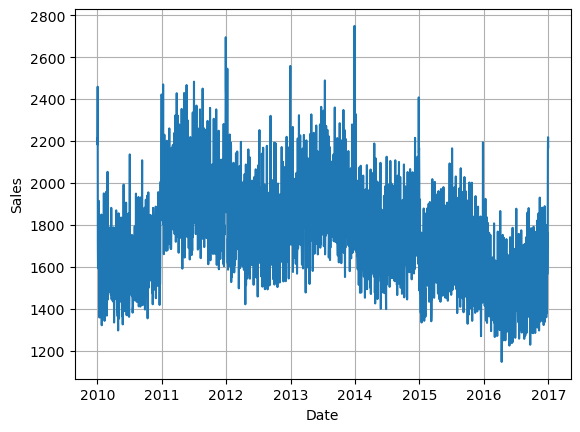

In [18]:
plot_group(data_grouped.get_group(('Canada','Premium Sticker Mart','Kaggle')))

In [19]:
# for group_name, df in data_pack_dt.groupby(group_categories,observed=True): 
    
#     plt.figure(figsize=(5, 2))
#     plt.plot(df['date'], df['num_sold'], label=f"{group_name}")
#     plt.xlabel("Date", fontsize=12)
#     plt.ylabel("Sales.", fontsize=12)
#     plt.grid(True)
#     plt.legend(title="Feature Combination")
#     plt.show()

## Normalized residuals, yearly means and amplitudes

To train our predictor we'll use a simple model in which the XGBoost predicts the sales dynamics within one year and the trends are predicted by linear regression. For that we first fit the yearly means by a line, subtract that mean from the sales and then normalize these residuals accordingly to another (supposedly, linear) trend of the annual amplitudes

\begin{equation}
{\rm num\_sold} = L_{\rm mean} ({\rm year}) + L_{\rm scale} ({\rm year}) \cdot {\rm XGBoost}({\rm day})
\end{equation}

_P.S. the algorithm seems to have problems in predicting too high sale outbursts and we'll use a simplistic procedure to "regularize" them to the mean value of yearly peaks}_

In [20]:
def residual_processing(df_input):

    df = df_input.copy()

    regression_coefficient = dict() # stores the regression coefficients for different category groups
    regression_index_mean = 1 # for linear regression
    regression_index_scale = 1 # for linear regression

    years = df['year'].unique() # list all the years in the dataframe

    #df.loc['norm_res'] = 0

    for group_name, dfg in df.groupby(group_categories,observed=True):

        yearly_mean = [] 
        yearly_scale = []
        yearly_max = [] # peak value for every year

        for year in years:

            dfg_year = dfg[dfg['year'] == year].copy()
            
            year_mean = dfg_year['num_sold'].mean()
            residuals = dfg_year['num_sold'] - year_mean
            year_scale = residuals.abs().mean() # the amplitude is estimated as the mean value of the absolute value of residuals
            norm_res = residuals/year_scale
            norm_res_max_value = (residuals/year_scale).max()

            dfg.loc[dfg_year.index,'norm_res'] = norm_res # add normalized residuals to the dataframe
            df.loc[dfg_year.index,'norm_res'] = norm_res

            yearly_mean.append( year_mean )
            yearly_scale.append( year_scale )
            yearly_max.append(norm_res_max_value)

        # Fitting the mean and the amplitude and extracting the coefficients
        coefs_mean = np.polyfit(years, yearly_mean, regression_index_mean) 
        coefs_scale = np.polyfit(years, yearly_scale, regression_index_scale)

        group_max_mean = np.mean(yearly_max) # determine the mean value of all the yearly peaks

        # "Cut" the peaks that are higher than the mean 
        dfg_max = dfg[dfg['norm_res'] > group_max_mean] 
        df.loc[dfg_max.index,'norm_res'] = group_max_mean

        regression_coefficient[group_name] = [coefs_mean,coefs_scale] # store the coefficients for the given group

        '''
        #Plot the results for each group
        fig = plt.figure(figsize=(10,4))

        # Left subplot
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(dfg['daysfromstart'].to_numpy(), dfg['num_sold'].to_numpy(),label='num_sold')  
        ax1.plot(365*(years-0.5), np.polyval(coefs_mean,years),'--',label='mean')
        #ax1.plot(dfg['daysfromstart'].to_numpy(), np.polyval(coefs_mean,dfg['daysfromstart'].to_numpy()),'--',label='mean')
        ax1.legend()
        ax1.grid()
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Num_sold')

        # Right subplot
        # ax2 = fig.add_subplot(1,2,2)
        # ax2.plot(dfg['daysfromstart'].to_numpy(), df.loc[dfg.index,'num_sold'].to_numpy() - np.polyval(coefs_mean,dfg['daysfromstart']/365) )
        # ax2.plot(365*(years-0.5), np.polyval(coefs_scale,years),'--',label='scale')
        # ax2.grid()
        # ax2.set_xlabel('Date')
        # ax2.set_ylabel('Residuals')

        plt.tight_layout()
        plt.title(f'{group_name}')
        plt.show()
        '''
        
    return df, regression_coefficient


Create the new dataframe and dictionary for regression coefficients

In [21]:
data_pack_new, reg_coefs = residual_processing(data_pack_nonans)
data_pack_new.head(2)

,id,date,country,store,product,num_sold,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,oddyear,daysfromstart,norm_res
1,1,2010-01-01 00:00:00,Canada,Discount Stickers,Kaggle,973.0,4,1,1,1.0,1,1,1,0,1.0,5.209233
2,2,2010-01-01 00:00:00,Canada,Discount Stickers,Kaggle Tiers,906.0,4,1,1,1.0,1,1,1,0,1.0,5.431465


# XGBoost

We'll use XGBoost method to predict the normalized residuals from the given dataset without any external information

## Split the training and test data

Preparing the training and test datasets

In [22]:
def train_test_split(df,split_date):

    train_data = df[df['date'] < split_date]
    test_data = df[df['date'] >= split_date]

    # Train on normalized residuals
    split_features = 'norm_res'
    
    train_target = train_data[split_features]
    train_data = train_data.drop(columns = split_features)
    test_target = test_data[split_features]
    test_data = test_data.drop(columns = split_features)

    return train_data, train_target, test_data, test_target

In [23]:
split_date = pd.to_datetime('2016-01-01') # use the last year data for testing the output
train_data, train_target, test_data, test_target = train_test_split(data_pack_new,split_date)

## Train the regressor

In [24]:
columns_to_drop = ['id','date','num_sold','daysfromstart','year'] # drop the unnecessary features from the training data

model = xgb.XGBRegressor(n_estimators=1000,
                        #early_stopping_rounds=10,
                        enable_categorical='True',
                        max_depth=8,
                        #max_leaves=15,
                        learning_rate=0.2,random_state=42)

start_time = time.time()
model.fit(train_data.drop(columns=columns_to_drop),train_target,
         #eval_set=[(train_data,train_target),(test_data,test_target)],
          verbose=True)
end_time = time.time()

print(f'Elapsed time: {end_time - start_time} s')

Elapsed time: 7.308746576309204 s


In [25]:
# Predicted targets
predictions = model.predict(test_data.drop(columns=columns_to_drop))

# Construct a prediction dataframe from the test one
df_predictions = test_data[['id','date','country','store','product','year']].copy()
df_predictions['norm_res'] = predictions
df_predictions['num_sold'] = 0.0

In [28]:
def recover_num_sold(df,reg_coefs):

    years = df['year'].unique()

    for year in years:
        
        for group_name, group_data in df.groupby(group_categories,observed=True):
        
            year_mean = np.polyval(reg_coefs[group_name][0],year)
            year_scale = np.polyval(reg_coefs[group_name][1],year)
    
            year_slice = group_data[group_data['year'] == year]
    
            df.loc[year_slice.index,'num_sold'] = df.loc[year_slice.index,'norm_res'][df['year'] == year]*year_scale + year_mean
        

Restore the 'num_sold' values in the prediction dataframe using the function above

In [29]:
recover_num_sold(df_predictions,reg_coefs)
df_predictions.head(5)

,id,date,country,store,product,year,norm_res,num_sold
197191,197191,2016-01-01 00:00:00,Canada,Discount Stickers,Kaggle,7.0,5.135592,950.919556
197192,197192,2016-01-01 00:00:00,Canada,Discount Stickers,Kaggle Tiers,7.0,5.451921,826.847046
197193,197193,2016-01-01 00:00:00,Canada,Discount Stickers,Kerneler,7.0,2.534988,401.680847
197194,197194,2016-01-01 00:00:00,Canada,Discount Stickers,Kerneler Dark Mode,7.0,2.569132,491.158264
197195,197195,2016-01-01 00:00:00,Canada,Stickers for Less,Holographic Goose,7.0,3.976640,281.210571


Evaluate the performance of our regression algorithm using the metric that we chosen for this competition - MAPE

In [30]:
print('MAPE = ',mean_absolute_percentage_error(test_data['num_sold'],df_predictions['num_sold']) )

MAPE =  0.06785643588615631


Now let's see the most essential features to divide the data on normalized residuals by XGBoost

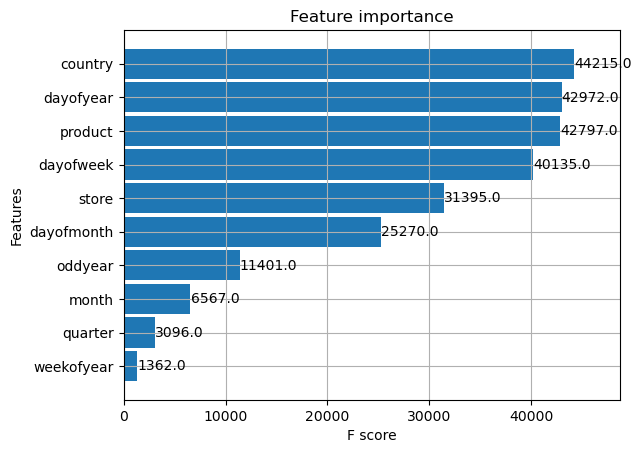

In [31]:
_ = xgb.plot_importance(model, height=0.9)

In [ ]:
# grouped_train = data_pack_new.groupby(group_categories,observed=True)
# grouped_prediction = df_predictions.groupby(group_categories,observed=True)

# for (group_name_train, group_data_train), (group_name_prediction, group_data_prediction) in zip(grouped_train,grouped_prediction):
#     plt.figure(figsize=(5, 2))
#     plt.plot(group_data_train['date'].to_numpy(), group_data_train['num_sold'].to_numpy())
#     plt.plot(group_data_prediction['date'].to_numpy(), group_data_prediction['num_sold'].to_numpy(),marker='o',linestyle='none')
#     plt.xlabel("Date", fontsize=12)
#     plt.ylabel("Sales", fontsize=12)
#     plt.grid(True)
#     plt.legend(title=f"{group_name_train}")
#     plt.show()

# Analyzing and filling NaNs

Now let's get back to the skipped NaN values and let's try to fill them by using the existing data and some conjectures.

We split the data by the groups according to how many NaNs they incorporate

In [32]:
# "Discount Stickers" have all NaNs
data_kenya_allnans = data_grouped.get_group(('Kenya', 'Discount Stickers', 'Holographic Goose'))
data_canada_allnans = data_grouped.get_group(('Canada', 'Discount Stickers', 'Holographic Goose'))
# "Stickers for Less" have a lot of NaNs
data_kenya_manynans = data_grouped.get_group(('Kenya', 'Stickers for Less', 'Holographic Goose'))
data_canada_manynans = data_grouped.get_group(('Canada', 'Stickers for Less', 'Holographic Goose'))
# "Premium Sticker Mart" have a small number of NaNs
data_kenya_somenans = data_grouped.get_group(('Kenya', 'Premium Sticker Mart', 'Holographic Goose'))
data_canada_somenans = data_grouped.get_group(('Canada', 'Premium Sticker Mart', 'Holographic Goose'))
# Kerneler in Kenya has 63 NaNs
data_kenya_kerneler = data_grouped.get_group(('Kenya', 'Discount Stickers', 'Kerneler'))


data_kenya_allnans.head(2)

,id,date,country,store,product,num_sold,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,oddyear,daysfromstart
45,45,2010-01-01 00:00:00,Kenya,Discount Stickers,Holographic Goose,NaN,4,1,1,1.0,1,1,1,0,1.0
135,135,2010-01-02 00:00:00,Kenya,Discount Stickers,Holographic Goose,NaN,5,1,1,1.0,2,2,1,0,2.0


We are going to construct regressors for each group individually

XGBoost regressor is not really needed here and supposedly a simpler regressor would do as well, but we'll stick to it

In [33]:
# Default arguments for the regressors used here
def_regressor_args = {
    "n_estimators": 1000,
    #early_stopping_rounds=10,
    "enable_categorical": 'True',
    "max_depth": 8,
    #"max_leaves": 15,
    "learning_rate": 0.05,
    "random_state": 42
}

# Function to construct the regressor, train it, predict the sales and return the final dataframe with the results
def predict_for_group_nans(df,df_train,regressor_args = def_regressor_args):

    df_new = df.copy()
    group_regressor = xgb.XGBRegressor(**regressor_args) 
    df_nans = df_new[df_new['num_sold'].isna()]
    df_processed, reg_coefs = residual_processing(df_train.dropna())
    
    group_regressor.fit(df_processed[date_categories],df_processed['norm_res'])

    prediction = group_regressor.predict(df_nans[date_categories])

    df_prediction = df_nans.copy()
    df_prediction.loc[:,'norm_res'] = prediction
    
    recover_num_sold(df_prediction,reg_coefs)

    df_full = df_new.copy()
    df_full.loc[df_nans.index,'num_sold'] = df_prediction['num_sold']

    return df_full

The missing values for "Holographic Goose" in "Premium Sticker Mart" in Kenya can be adequatelly restored from the existing data

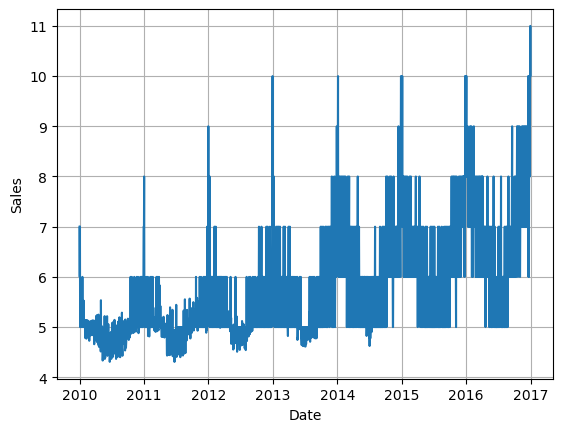

In [34]:
data_kenya_somenans_filled = predict_for_group_nans(data_kenya_somenans,data_kenya_somenans)

plot_group(data_kenya_somenans_filled)

The same goes for Canada (although the sales in 2015 and 2016 look quite asymmetric)

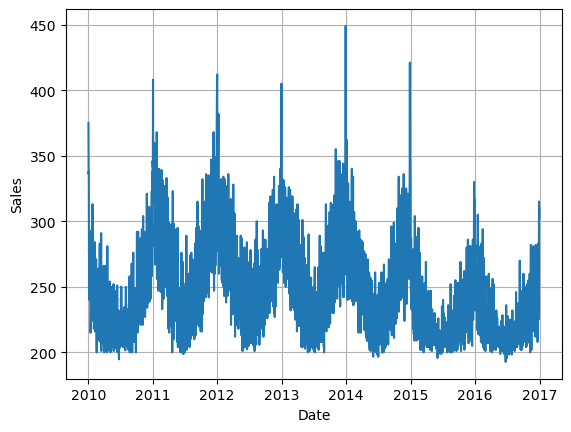

In [35]:
data_canada_somenans_filled = predict_for_group_nans(data_canada_somenans,data_canada_somenans)

plot_group(data_canada_somenans_filled)

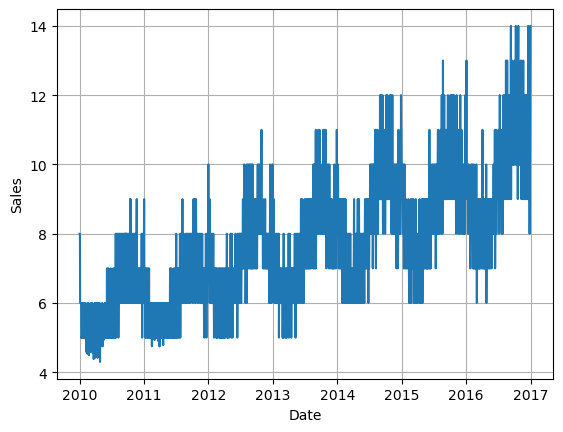

In [36]:
data_kenya_kerneler_filled = predict_for_group_nans(data_kenya_kerneler,data_kenya_kerneler)

plot_group(data_kenya_kerneler_filled)

The other groups have too many NaN values to adequately fill them with the regressors trained on the existing data, so we have to use some conjectures. 

We employ the observation that the ratio of 'Holographic Goose' sales in different shops and different stores are very similar, so we can use these ratios to construct the training datasets for individual regressors

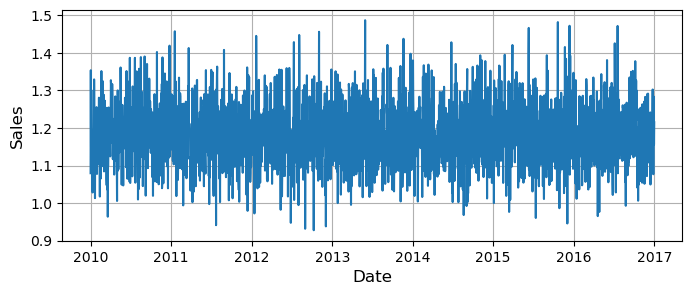

mean ratio:  1.1829440613357247


In [37]:
check_country = 'Norway'

df1 = data_grouped.get_group((check_country, 'Premium Sticker Mart', 'Holographic Goose'))
df2 = data_grouped.get_group((check_country, 'Stickers for Less', 'Holographic Goose'))

plt.figure(figsize=(8, 3))
plt.plot(df1['date'].to_numpy(), df1.num_sold.to_numpy()/df2.num_sold.to_numpy())
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.grid(True)
plt.show()

print('mean ratio: ',np.mean(df1.num_sold.to_numpy()/df2.num_sold.to_numpy()))

In a similar fashion one can check the other groups of countries ans stores and derive the ratios for them

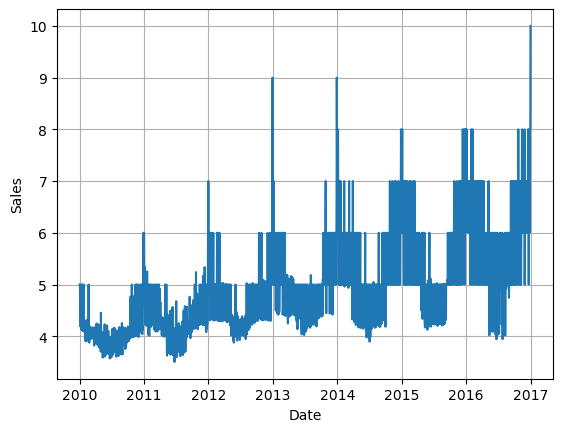

In [38]:
# Construct the training dataset using the ratio information
data_kenya_manynans_recovered = data_kenya_manynans.copy()
data_kenya_manynans_recovered.loc[:,'num_sold'] = data_kenya_somenans_filled['num_sold'].to_numpy()/1.185

data_kenya_manynans_filled = predict_for_group_nans(data_kenya_manynans,data_kenya_manynans_recovered)
plot_group(data_kenya_manynans_filled)

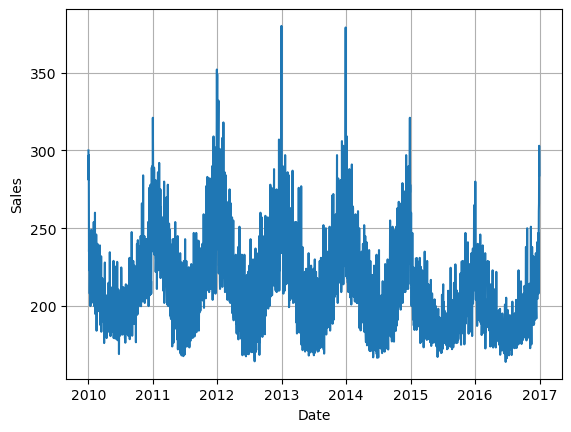

In [39]:
data_canada_manynans_recovered = data_canada_manynans.copy()
data_canada_manynans_recovered.loc[:,'num_sold'] = data_canada_somenans_filled['num_sold'].to_numpy()/1.185

data_canada_manynans_filled = predict_for_group_nans(data_canada_manynans,data_canada_manynans_recovered)
plot_group(data_canada_manynans_filled)

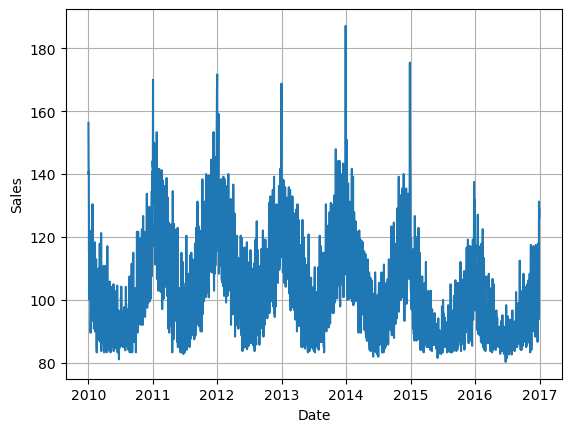

In [40]:
data_canada_allnans_recovered = data_canada_allnans.copy()
data_canada_allnans_recovered.loc[:,'num_sold'] = data_canada_somenans_filled['num_sold'].to_numpy()/2.4

data_canada_allnans_filled = predict_for_group_nans(data_canada_allnans,data_canada_allnans_recovered)
plot_group(data_canada_allnans_recovered)

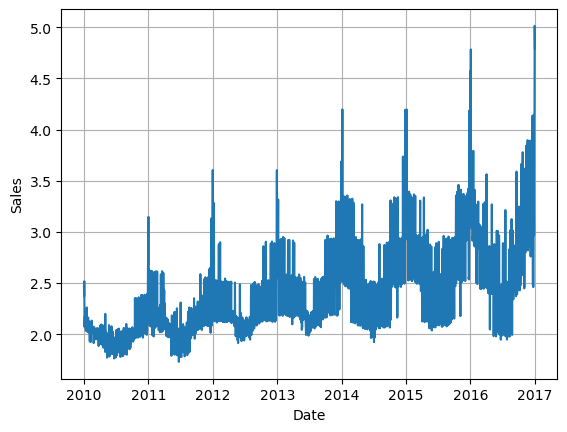

In [41]:
data_kenya_allnans_recovered = data_kenya_allnans.copy()
data_kenya_allnans_recovered.loc[:,'num_sold'] = data_kenya_somenans_filled['num_sold'].to_numpy()/2.4

data_kenya_allnans_filled = predict_for_group_nans(data_kenya_allnans,data_kenya_allnans_recovered)
plot_group(data_kenya_allnans_filled)

We'll take a "recovered" dataset though, as it looks a bit better

In [42]:
data_kenya_allnans_filled.loc[:,'num_sold'] = data_kenya_allnans_recovered['num_sold']

## Filling NaNs

Adding the reconstructed values to the original dataset

In [43]:
data_pack_dt_filled = data_pack_dt.copy()
print('NaNs at the beginning: ',data_pack_dt_filled['num_sold'].isna().sum())
#print(data_pack_dt_filled.shape)

data_pack_dt_filled.loc[data_canada_manynans_filled.index,'num_sold'] = data_canada_manynans_filled['num_sold']
data_pack_dt_filled.loc[data_canada_somenans_filled.index,'num_sold'] = data_canada_somenans_filled['num_sold']
data_pack_dt_filled.loc[data_kenya_somenans_filled.index,'num_sold'] = data_kenya_somenans_filled['num_sold']
data_pack_dt_filled.loc[data_kenya_manynans_filled.index,'num_sold'] = data_kenya_manynans_filled['num_sold']
data_pack_dt_filled.loc[data_kenya_allnans_filled.index,'num_sold'] = data_kenya_allnans_filled['num_sold']
data_pack_dt_filled.loc[data_canada_allnans_filled.index,'num_sold'] = data_canada_allnans_filled['num_sold']
data_pack_dt_filled.loc[data_kenya_kerneler_filled.index,'num_sold'] = data_kenya_kerneler_filled['num_sold']

print('NaNs after filling: ',data_pack_dt_filled['num_sold'].isna().sum())
#print(data_pack_dt_filled.isna().sum())

# The other 2 NaNs we'll simply neglect
data_pack_dt_filled = data_pack_dt_filled.dropna()

print('NaNs finally: ',data_pack_dt_filled['num_sold'].isna().sum())

NaNs at the beginning:  8871
NaNs after filling:  2
NaNs finally:  0


## Testing the filled dataset

In [44]:
data_pack_filled, reg_coefs = residual_processing(data_pack_dt_filled)

train_data_filled, train_target_filled, test_data_filled, test_target_filled = train_test_split(data_pack_filled,split_date)

# We train the same regressor as we used before
start_time = time.time()
model.fit(train_data_filled.drop(columns=columns_to_drop),train_target_filled,
         #eval_set=[(train_data,train_target),(test_data,test_target)],
          verbose=True)
end_time = time.time()

print(f'Elapsed time: {end_time - start_time} s')

predictions_filled = model.predict(test_data_filled.drop(columns=columns_to_drop))

df_predictions_filled = test_data_filled[['id','date','country','store','product','year']].copy()
df_predictions_filled['norm_res'] = predictions_filled

recover_num_sold(df_predictions_filled,reg_coefs)

print('MAPE = ', mean_absolute_percentage_error(test_data['num_sold'],df_predictions['num_sold']) )

df_predictions_filled.head(3)

Elapsed time: 6.137339353561401 s
MAPE =  0.06785643588615631


,id,date,country,store,product,year,norm_res,num_sold
197190,197190,2016-01-01 00:00:00,Canada,Discount Stickers,Holographic Goose,7.0,5.450928,137.026077
197191,197191,2016-01-01 00:00:00,Canada,Discount Stickers,Kaggle,7.0,5.273213,958.397156
197192,197192,2016-01-01 00:00:00,Canada,Discount Stickers,Kaggle Tiers,7.0,5.405961,824.564209


# Final prediction

In [71]:
inference_data = datetime_processing(inference_pack)
inference_data.head(2)

In [76]:
# We separate the training data from the target data using the same method we constructed earlier and setting the splitting date such that no test dataset is created
train_data_final, target_data_final, _, _ = train_test_split(data_pack_filled,pd.to_datetime('2020-01-01'))

In [75]:
columns_to_drop_final = ['id','date','num_sold','year','daysfromstart','quarter','weekofyear']
# quarter and week of year didn't play any significant role in the prediction according to the previous regressor's estimate

model_final = xgb.XGBRegressor(n_estimators=1000,
                        #early_stopping_rounds=10,
                        enable_categorical='True',
                        max_depth=10,
                        #max_leaves=6,
                        learning_rate=0.2,random_state=42)
start_time = time.time()
model_final.fit(train_data_final.drop(columns=columns_to_drop_final),target_data_final,
         #eval_set=[(train_data,train_target),(test_data,test_target)],
          verbose=True)
end_time = time.time()

print(f'Elapsed time: {end_time - start_time} s')

Elapsed time: 14.149081707000732 s


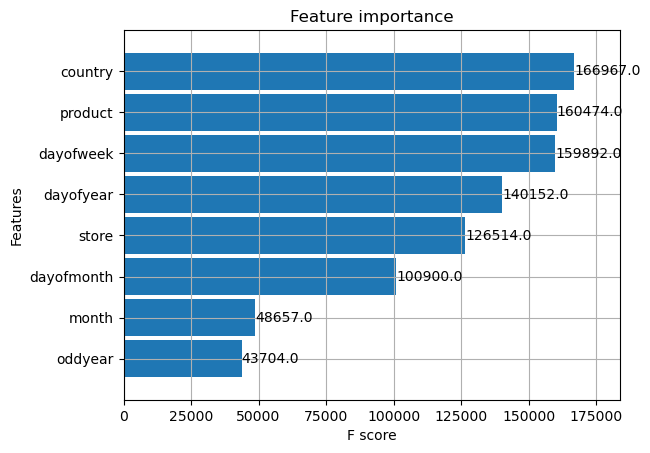

In [92]:
_ = xgb.plot_importance(model_final, height=0.9)

In [88]:
predictions_final = model_final.predict(inference_data.drop(columns=['id','date','year','daysfromstart','quarter','weekofyear']))

df_predictions_final = pd.DataFrame( inference_data[['id','date','country','store','product','year']].copy() )
df_predictions_final.loc[:,'norm_res'] = predictions_final
df_predictions_final.loc[:,'num_sold'] = 0.0

recover_num_sold(df_predictions_final,reg_coefs)

Plot the results

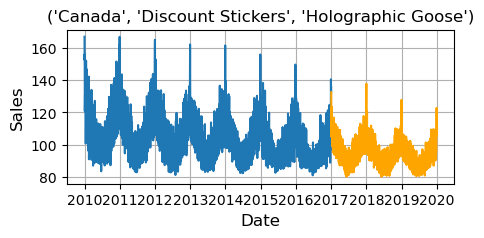

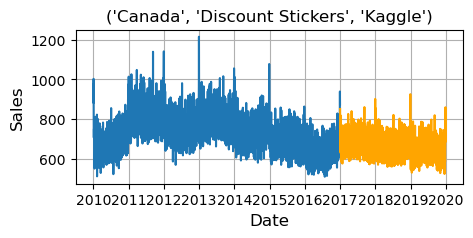

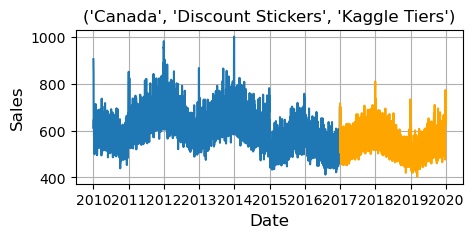

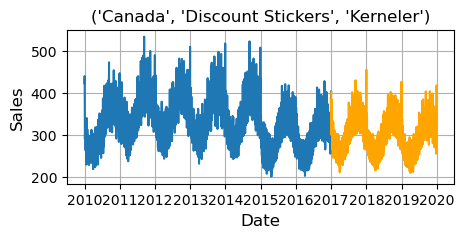

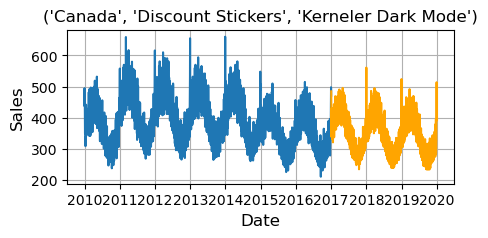

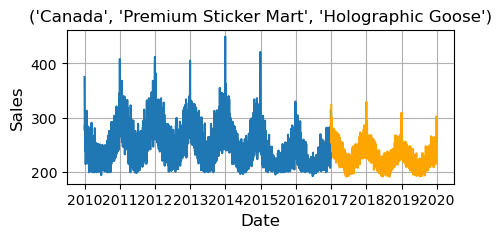

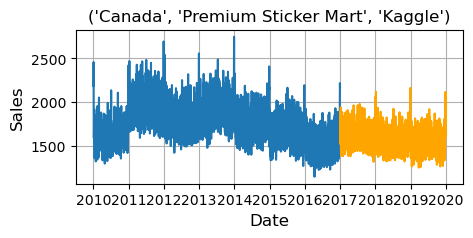

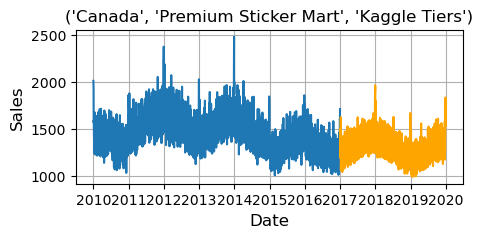

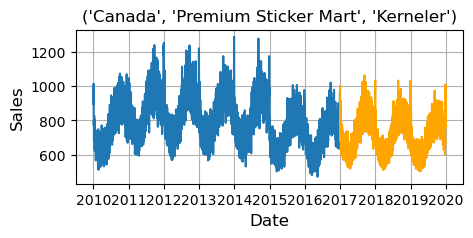

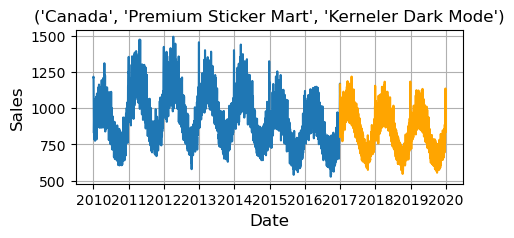

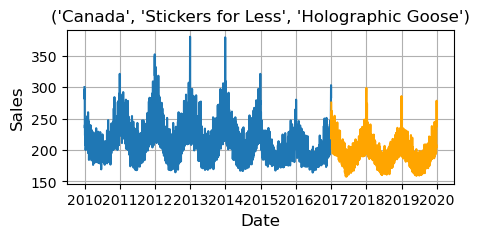

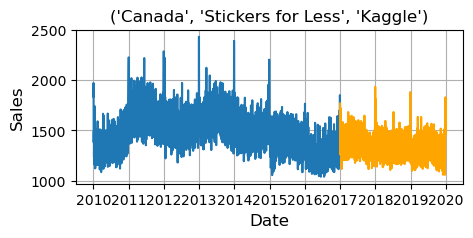

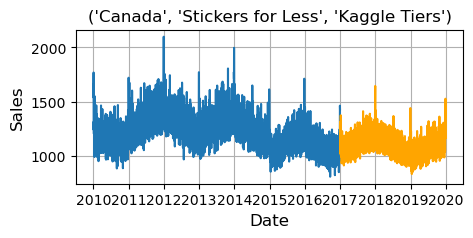

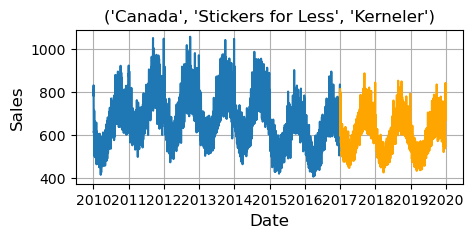

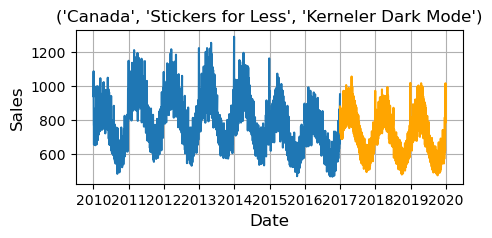

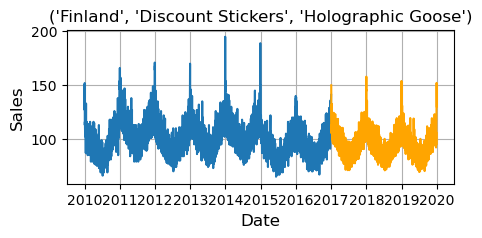

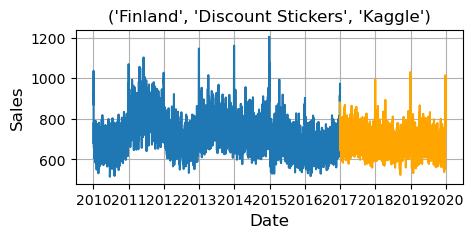

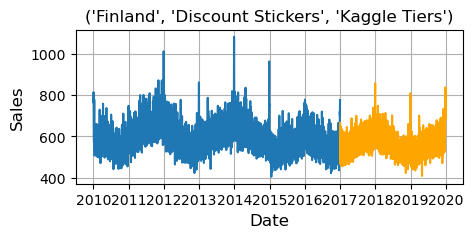

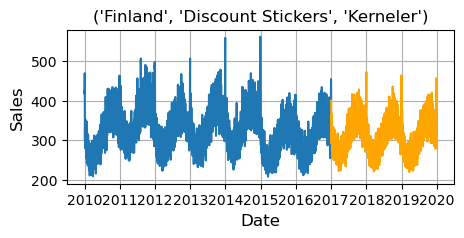

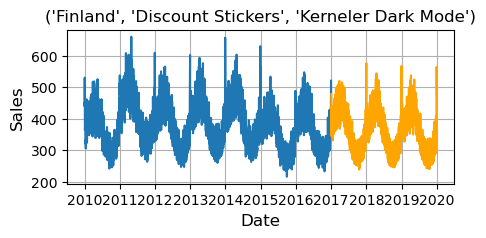

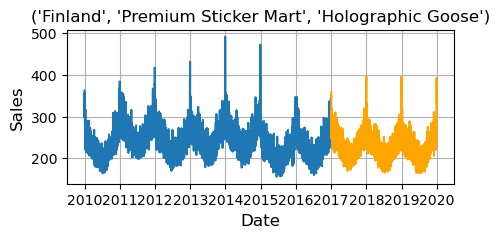

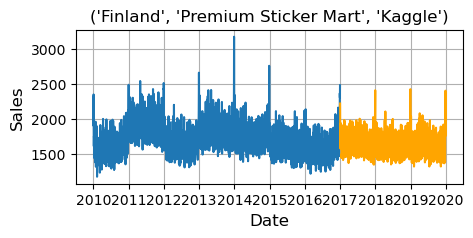

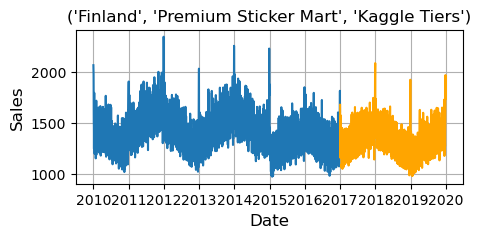

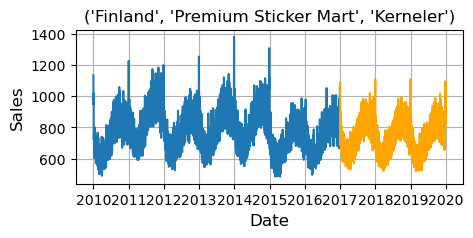

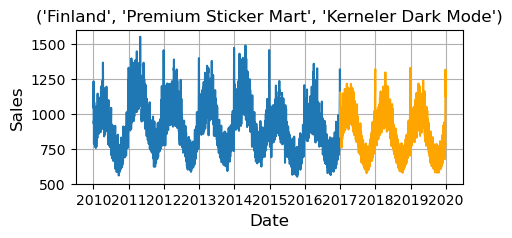

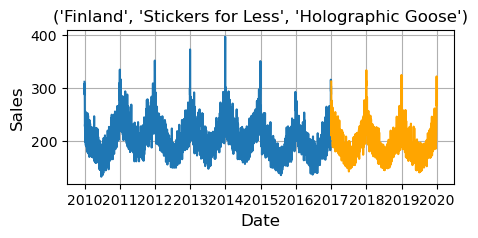

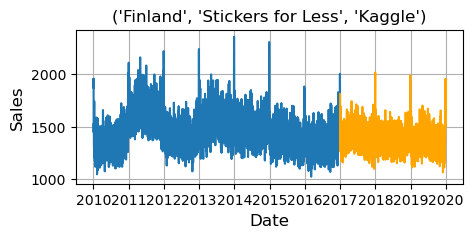

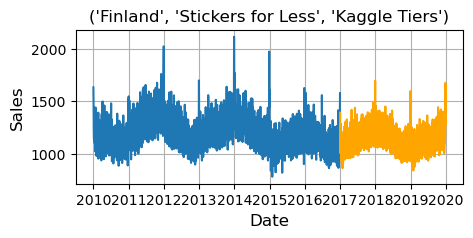

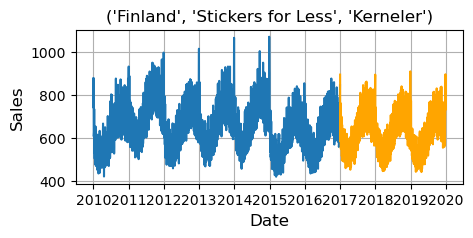

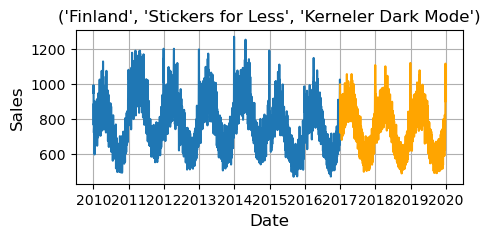

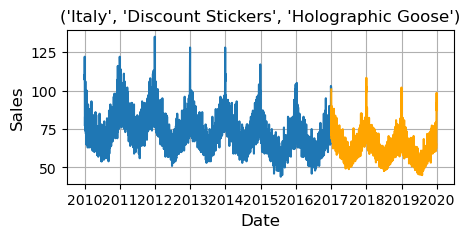

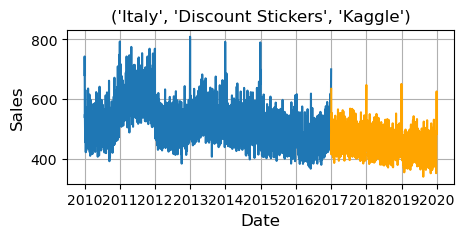

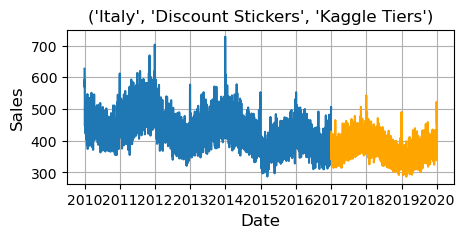

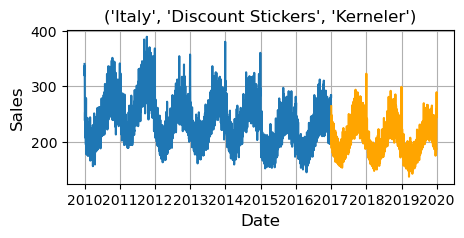

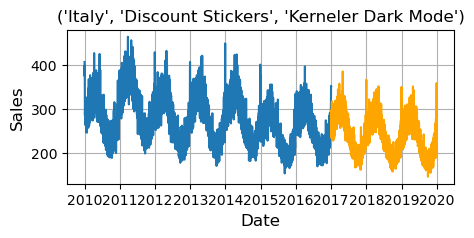

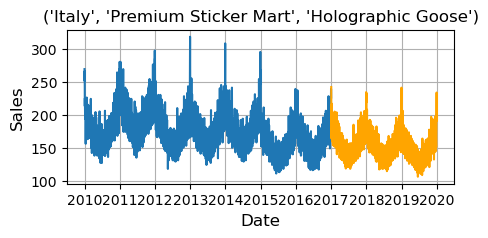

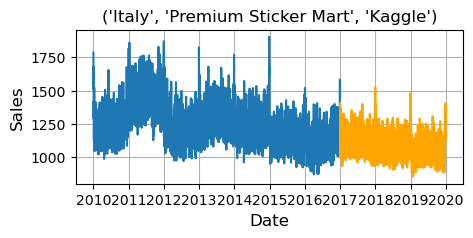

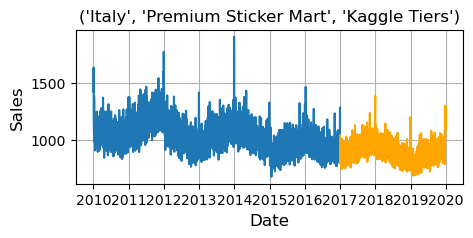

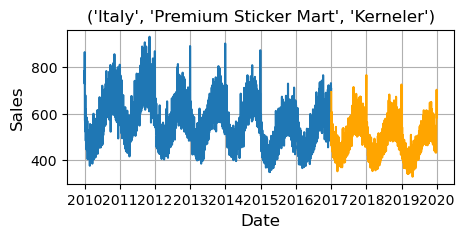

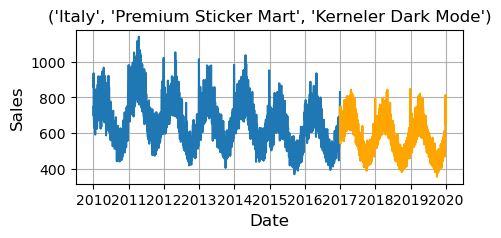

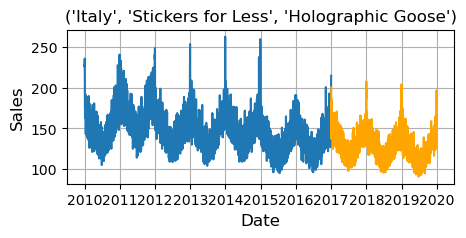

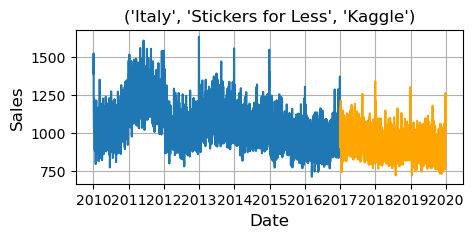

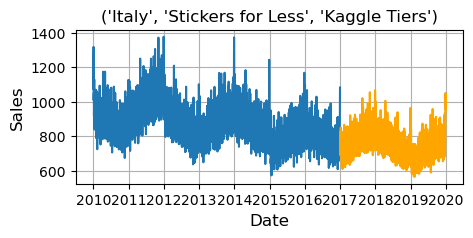

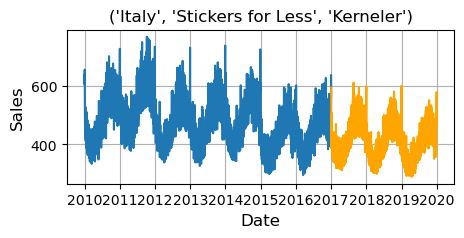

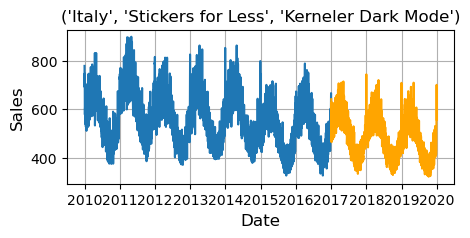

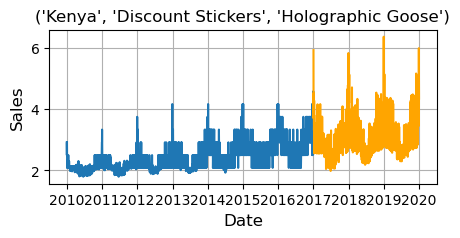

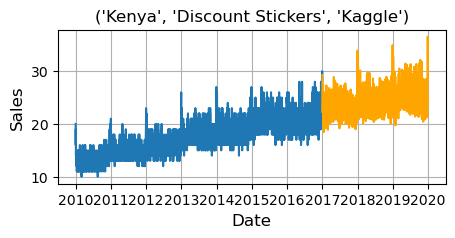

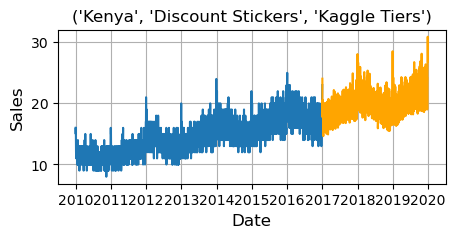

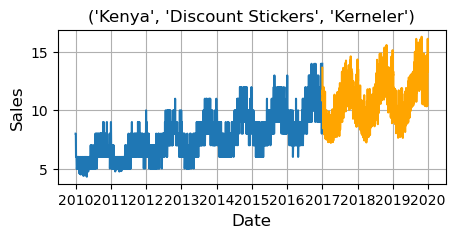

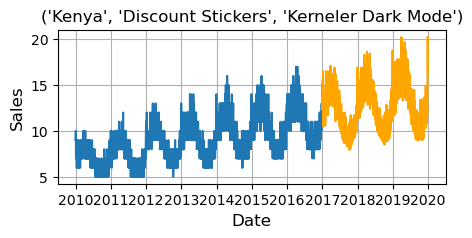

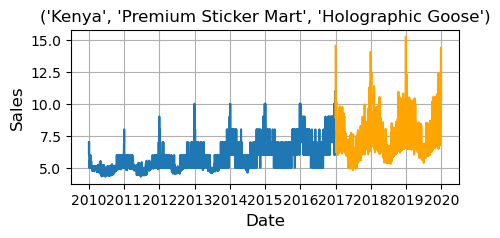

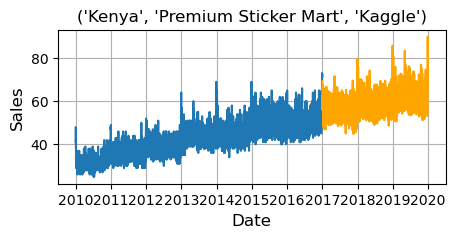

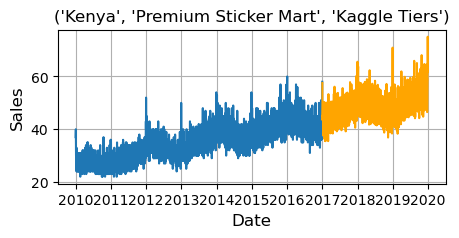

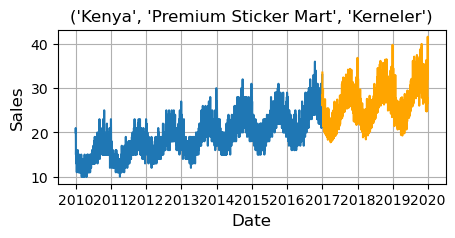

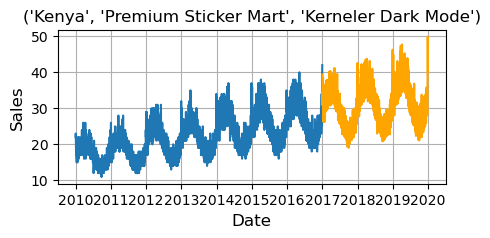

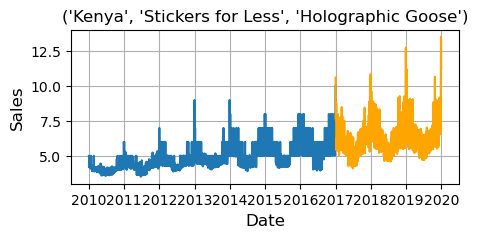

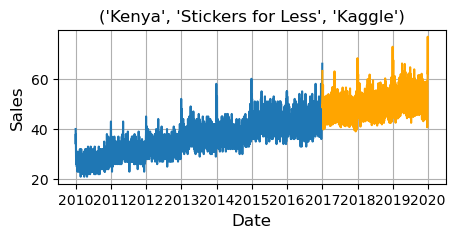

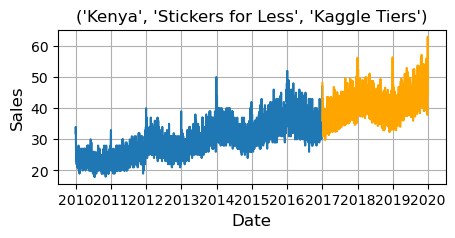

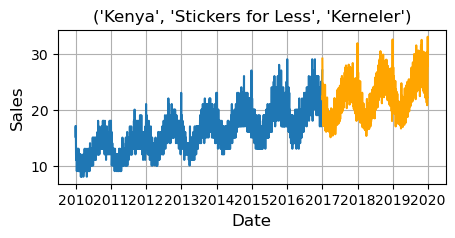

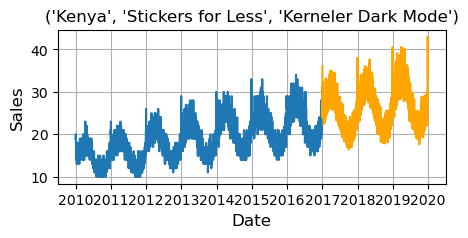

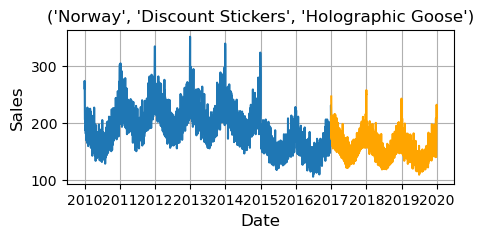

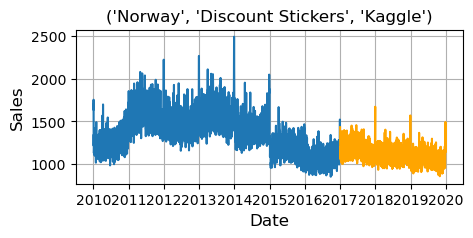

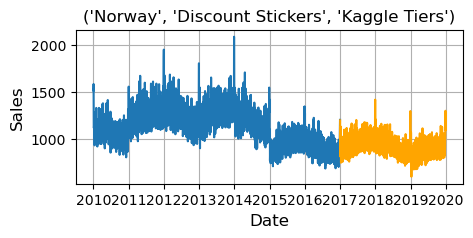

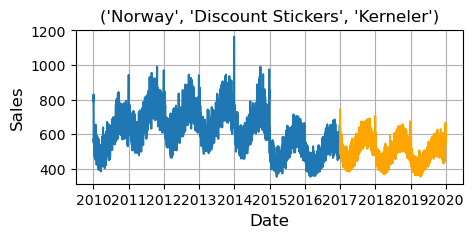

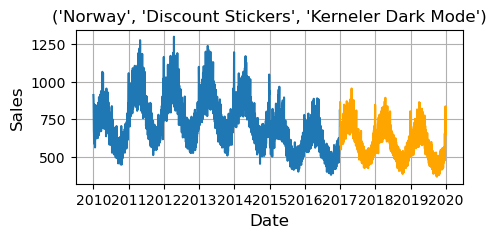

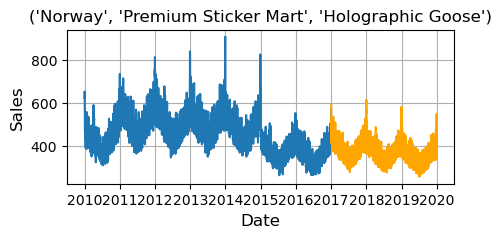

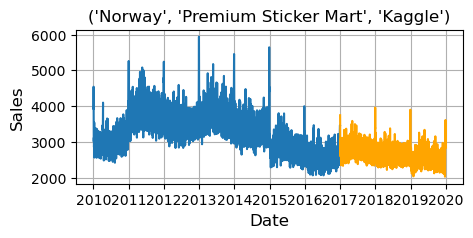

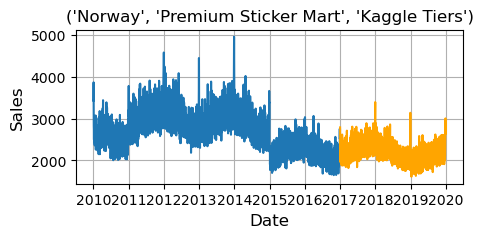

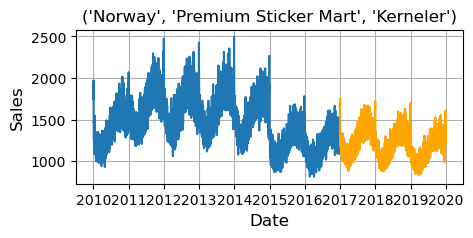

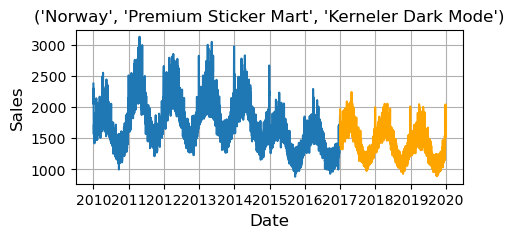

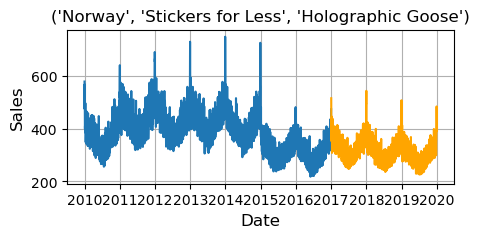

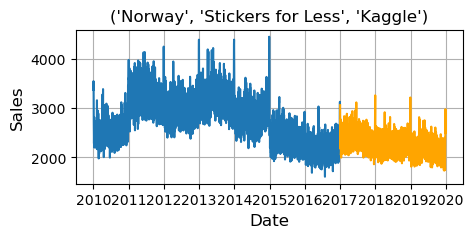

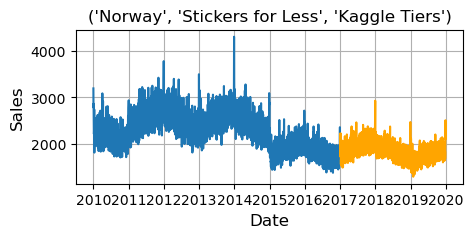

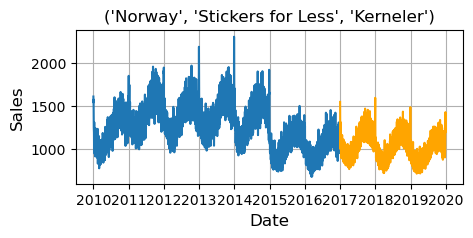

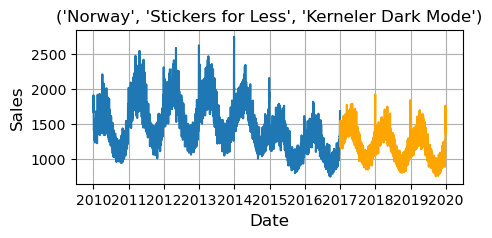

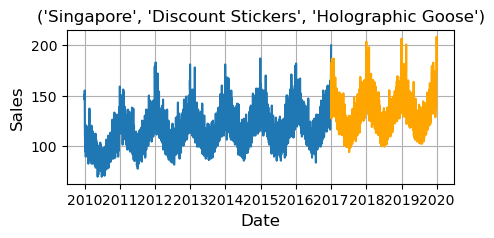

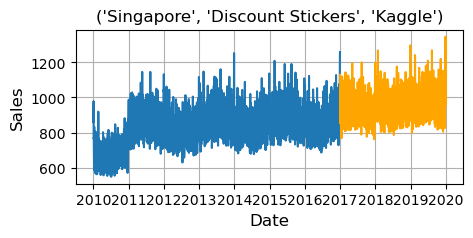

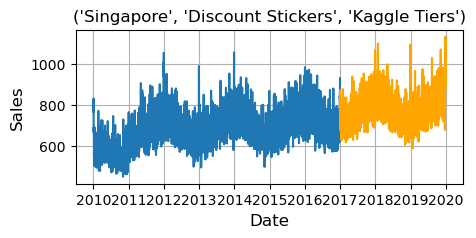

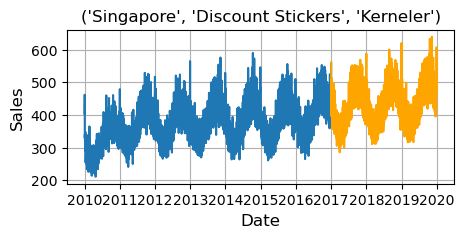

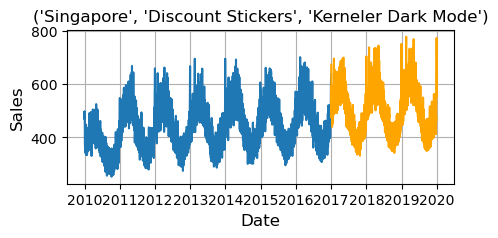

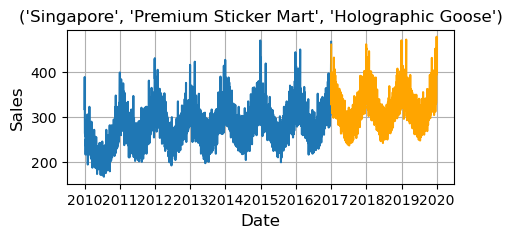

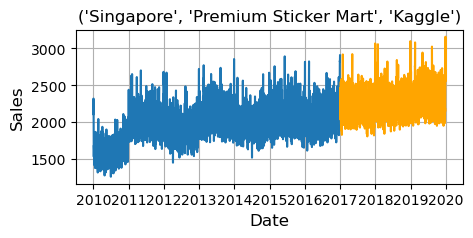

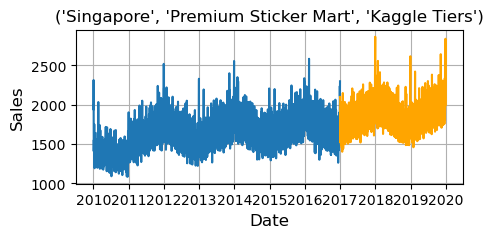

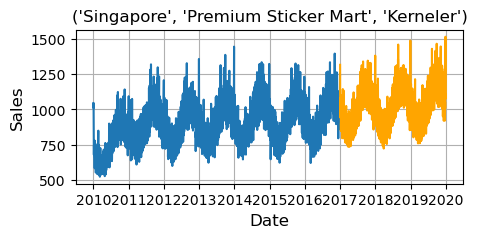

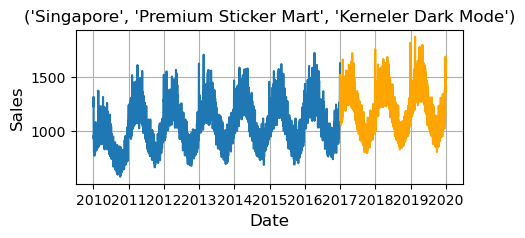

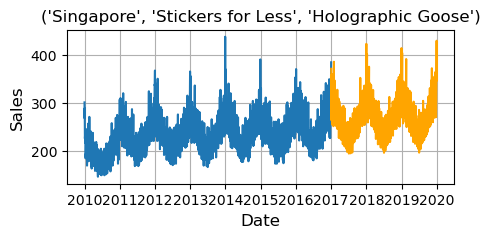

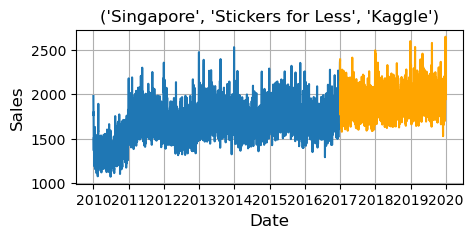

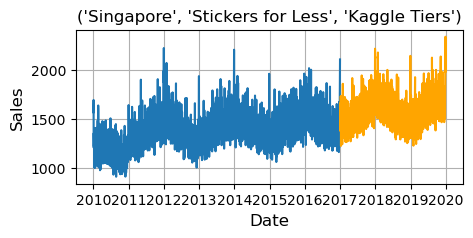

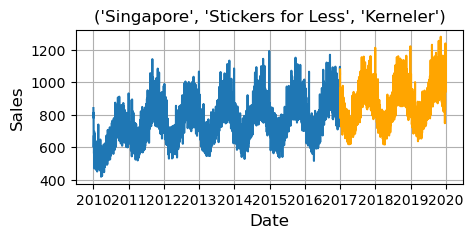

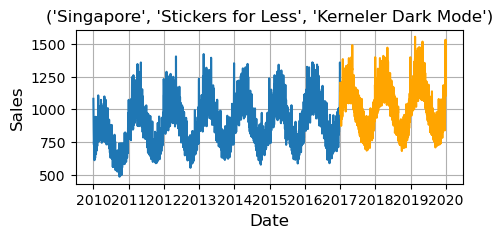

In [89]:
df_train_full_grouped = data_pack_filled.groupby(group_categories,observed=True)

for group_name, df_prediction in df_predictions_final.groupby(group_categories,observed=True):

    df_train = df_train_full_grouped.get_group(group_name)
    
    plt.figure(figsize=(5, 2))
    plt.plot(df_train['date'].to_numpy(), df_train['num_sold'].to_numpy())
    plt.plot(df_prediction['date'].to_numpy(), df_prediction['num_sold'].to_numpy(),color='orange')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Sales", fontsize=12)
    plt.grid(True)
    plt.title(f"{group_name}")
    plt.show()

Create the submission file

In [90]:
prediction_df = pd.DataFrame(df_predictions_final['id'].copy())
prediction_df['num_sold'] = df_predictions_final['num_sold']

prediction_df.to_csv('submission.csv', index=False)

In [91]:
prediction_df.head(5)

,id,num_sold
0,230130,132.486450
1,230131,850.446228
2,230132,715.762146
3,230133,402.365387
4,230134,484.811462
